# Data loading

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

In [3]:
jar = pd.read_csv('clean_data.csv')

fdData = [[] for _ in range(7)]
fdVals = jar['FD'].unique()

for i, val in enumerate(fdVals):
    fd = jar[jar['FD'] == val]
    fd = fd.drop(['FD', 'fuel_gas_swelling'], axis=1)
    fdData[i] = fd

In [4]:
hi_data = fdData[-1]

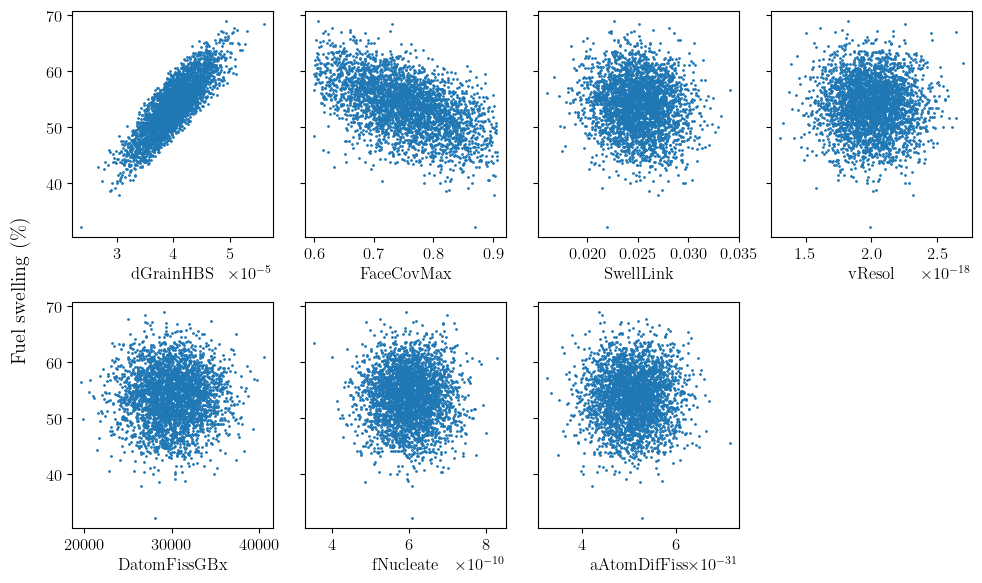

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(hi_data.iloc[:,i], hi_data.iloc[:,7], s=1)
    ax.set_xlabel(hi_data.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel swelling (\%)')
plt.tight_layout()
plt.show()

# Train/test split

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [7]:
feat_ind = list(range(7))
features = hi_data.iloc[:, feat_ind]
xscaler = MinMaxScaler()
X = xscaler.fit_transform(features)
y = hi_data['fuel_swelling']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Convenience functions

In [9]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [10]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [11]:
def pred_vs_actual(mod, X_test, y_test, tt):
    y_pred = mod.predict(X_test)

    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 16})
    
    plt.scatter(y_test, y_pred, s=15)
    plt.plot(list(range(30, 70)), list(range(30, 70)),
            color='k', ls='--', label='y=x')

    plt.title(tt)
    plt.xlabel(r'Test data (swelling \%)')
    plt.ylabel(r'Surrogate pred. (swelling \%)')
    plt.legend()
    plt.show()

# Linear (OLS)

In [12]:
from sklearn import linear_model

 coeffs:  [ 3.32077011e+01 -1.15098683e+01 -3.70051230e+00 -1.33183272e-15
  1.81245713e-01  1.93481033e-02 -1.46434539e-28] 
 intercept:  44.49165503999078
 R2:  0.9970846062553819 
 RMSE:  0.2534527955169139 
 MAE:  0.17350338094342774


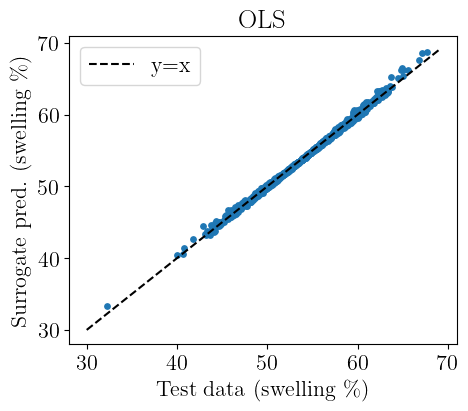

In [13]:
reg_lin = linear_model.LinearRegression().fit(X_train, y_train)

lin_coef_cept(reg_lin)
mod_metrics(reg_lin, X_test, y_test)
pred_vs_actual(reg_lin, X_test, y_test, 'OLS')

# Lasso

 coeffs:  [ 32.95486777 -11.42921494  -3.50783771  -0.           0.
   0.           0.        ] 
 intercept:  44.5834390627939
 R2:  0.9970590561822256 
 RMSE:  0.2545609839415487 
 MAE:  0.17441991927236164


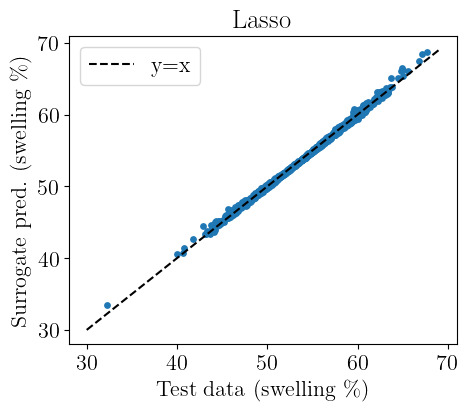

In [14]:
reg_las3 = linear_model.Lasso(
        alpha=0.0039, random_state=42
    ).fit(X_train, y_train)

#print(' alpha: ', reg_las3.alpha_)
lin_coef_cept(reg_las3)
mod_metrics(reg_las3, X_test, y_test)
pred_vs_actual(reg_las3, X_test, y_test, 'Lasso')

# LassoCV

 alpha:  0.0005531773475918996
 coeffs:  [ 33.17167238 -11.49840032  -3.67290108  -0.           0.15526971
   0.           0.        ] 
 intercept:  44.5133267596561
 R2:  0.9970918098647723 
 RMSE:  0.2531394752050807 
 MAE:  0.17320340758842637


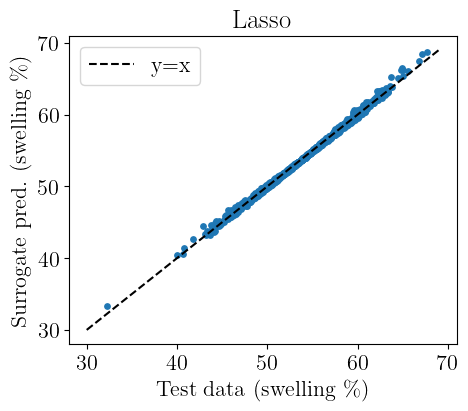

In [15]:
reg_lasso = linear_model.LassoCV(
        cv=5, random_state=42
    ).fit(X_train, y_train)

print(' alpha: ', reg_lasso.alpha_)
lin_coef_cept(reg_lasso)
mod_metrics(reg_lasso, X_test, y_test)
pred_vs_actual(reg_lasso, X_test, y_test, 'Lasso')

# Bayesian ridge

 coeffs:  [ 3.32074575e+01 -1.15098424e+01 -3.70049300e+00  2.92646330e-10
  1.81244158e-01  1.93449680e-02  2.67266277e-23] 
 intercept:  44.49175734056205
 R2:  0.9970847208020613 
 RMSE:  0.2534478163504883 
 MAE:  0.17350114944910403


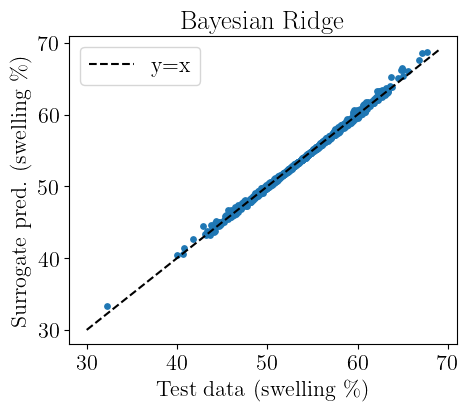

In [16]:
reg_bayr = linear_model.BayesianRidge().fit(X_train, y_train)

lin_coef_cept(reg_bayr)
mod_metrics(reg_bayr, X_test, y_test)
pred_vs_actual(reg_bayr, X_test, y_test, 'Bayesian Ridge')

# GP

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [18]:
tX_train, _, ty_train, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=17
)

In [19]:
tX_train[:, :3].shape

(448, 3)

In [20]:
len(ty_train)

448

In [21]:
#kern = DotProduct() + WhiteKernel()
kern = 1.0*RBF()
reg_gp = GaussianProcessRegressor(
    kernel=kern,
    alpha=1e-3,
    n_restarts_optimizer=9,
    random_state=42
)
reg_gp.fit(tX_train[:, :3], ty_train)

/home/atom/research/wd-swelling/.swel/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9, random_state=42)

In [22]:
reg_gp.kernel_

61.9**2 * RBF(length_scale=2.96)

 R2:  0.9998059500717934 
 RMSE:  0.06538907895949736 
 MAE:  0.04359685589667681


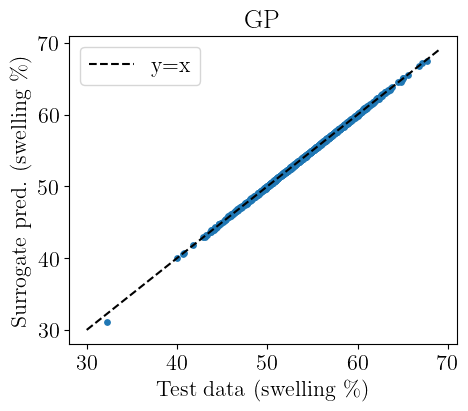

In [23]:
mod_metrics(reg_gp, X_test[:, :3], y_test)
pred_vs_actual(reg_gp, X_test[:, :3], y_test, 'GP')

# NN

In [24]:
from sklearn.neural_network import MLPRegressor

In [25]:
reg_nn = MLPRegressor(
    hidden_layer_sizes=(30, 50, 30),
    alpha=0,
    random_state=37,
    max_iter=5000,
    tol=0.1
).fit(X_train, y_train)

 R2:  0.9936644385100483 
 RMSE:  0.3736293910584673 
 MAE:  0.27877522648428793


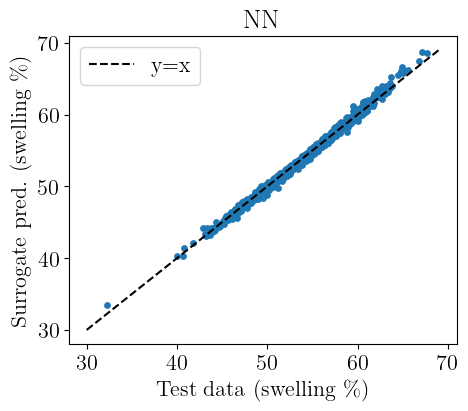

In [26]:
mod_metrics(reg_nn, X_test, y_test)
pred_vs_actual(reg_nn, X_test, y_test, 'NN')

In [27]:
## Manually updating weights and biases of the NN
## To make it the same as Ordinary Least Squares

#weights = reg_nn.coefs_
#for i, coef in enumerate(weights):
#    print(f'Layer {i} to {i+1}')
#    print(coef)
#
#weights[0][0] = 33.17
#weights[0][1] = -11.5
#weights[0][2] = 3.67
#weights[0][3] = 0
#weights[0][4] = 0.155
#weights[0][5] = 0
#weights[0][6] = 0
#weights[1][0] = 1
#
#biases = reg_nn.intercepts_
#for i, intercept in enumerate(biases):
#    print(f'Layer {i} to {i+1}')
#    print(intercept)
#
#biases[0][0] = 0
#biases[1][0] = 40.51

# SVR

In [28]:
from sklearn.svm import SVR

 R2:  0.9936518251889057 
 RMSE:  0.37400113113489253 
 MAE:  0.17171006231886668


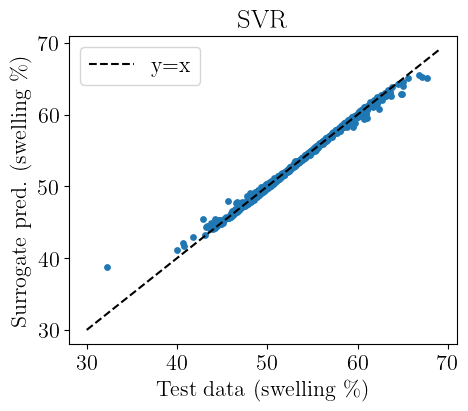

In [29]:
reg_svr = SVR(kernel='rbf').fit(X_train, y_train)

#lin_coef_cept(reg_svr)
mod_metrics(reg_svr, X_test, y_test)
pred_vs_actual(reg_svr, X_test, y_test, 'SVR')

# Target

In [30]:
def swelling_perc(fd):
    #return 6.13e-43 * fd**2 + 4e-21 * fd
    return 3.83e-43 * fd**2 + 4.54e-21 * fd

target = norm(swelling_perc(7e21), 1.25)

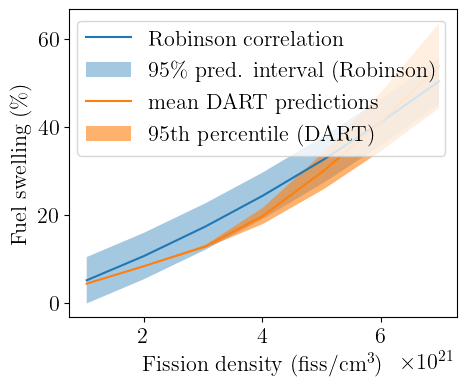

In [31]:
y_exp = [swelling_perc(x) for x in fdVals]

plt.plot(fdVals, y_exp, label='Robinson correlation')
exp_hi = [y + 5.28 for y in y_exp]
exp_lo = [y - 5.28 for y in y_exp]
plt.fill_between(fdVals, exp_lo, exp_hi, alpha=0.4,
                 label=r'95\% pred. interval (Robinson)')

y_mod = []
e_mod = []
for x, data in zip(fdVals, fdData):
    y_mod.append(mean(data['fuel_swelling']))
    e_mod.append(stdev(data['fuel_swelling']))

plt.plot(fdVals, y_mod, label='mean DART predictions')
mod_hi = [i + 2*j for i, j in zip(y_mod, e_mod)]
mod_lo = [i - 2*j for i, j in zip(y_mod, e_mod)]
plt.fill_between(fdVals, mod_lo, mod_hi, alpha=0.6,
                 label='95th percentile (DART)')

plt.xlabel(r'Fission density (fiss/cm$^3$)')
plt.ylabel(r'Fuel swelling (\%)')

plt.legend()
plt.show()

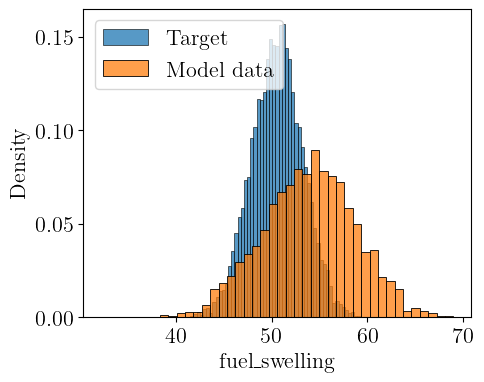

In [32]:
sns.histplot(np.random.normal(swelling_perc(7e21), 2.7, 10000),
             stat='density', label='Target')
sns.histplot(fdData[-1]['fuel_swelling'],
             stat='density', label='Model data')

plt.legend()
plt.show()

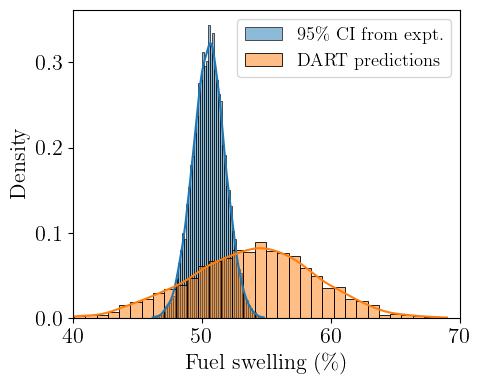

In [33]:
sns.histplot(np.random.normal(swelling_perc(7e21), 1.25, 10000),
             stat='density', kde=True, label=r'95\% CI from expt.')
sns.histplot(fdData[-1]['fuel_swelling'],
             stat='density', kde=True, label='DART predictions')

plt.xlim([40, 70])
plt.xlabel(r'Fuel swelling (\%)')
plt.legend(fontsize='small')
plt.show()
#plt.savefig('target.pdf')

# MCMC

In [34]:
def proposal_dist(X, sig):
    ret = []
    
    for el in X:
        prop = np.random.normal(el, sig)
        ret.append(prop)

    ## for Lasso
    #for dd in [4, 5, 6, 7]:
    #    ret[dd-1] = 0.5
        
    assert len(X) == len(ret)
    return ret

In [35]:
proposal_dist(np.random.rand(7), 0.3)

[0.40048950997415766,
 0.7441949817666162,
 0.69558556954233,
 0.23908709678256557,
 -0.27785005015868475,
 0.7692835766106237,
 0.15694860133287739]

In [36]:
def mcmc_sampler(num_param, initial_state, proposal_sig,
                 surrogate, target_fn, num_samples):
    samples = [initial_state]
    accepted = 0

    for ii in range(num_samples):
        current_state = samples[-1]
        proposed_state = proposal_dist(current_state, proposal_sig)

        valid = True
        for xx in proposed_state:
            if xx < 0 or xx > 1:
                valid = False
                break

        fs_curr = surrogate.predict([[*current_state]])[0]
        fs_prop = surrogate.predict([[*proposed_state]])[0]

        acceptance_ratio = target_fn.pdf(fs_prop) / target_fn.pdf(fs_curr)
        
        if valid and np.random.rand() < acceptance_ratio:
            current_state = proposed_state
            accepted += 1

        samples.append(current_state)

    print(f"Acceptance rate: {accepted / num_samples}")
    return np.array(samples)

In [37]:
hey1 = mcmc_sampler(
    3,
    np.random.rand(3),
    0.13,
    reg_gp,
    target,
    100000
)

Acceptance rate: 0.24624


In [38]:
np.save('smpl1.npy', hey1)

In [39]:
hey2 = mcmc_sampler(
    3,
    np.random.rand(3),
    0.13,
    reg_gp,
    target,
    100000
)

Acceptance rate: 0.24545


In [40]:
np.save('smpl2.npy', hey2)

# Trace/Hist

In [41]:
zeros = np.zeros((100001, 4))

yeh1 = np.concatenate((hey1, zeros), axis=1)
yeh2 = np.concatenate((hey2, zeros), axis=1)

old1 = xscaler.inverse_transform(yeh1)
old2 = xscaler.inverse_transform(yeh2)

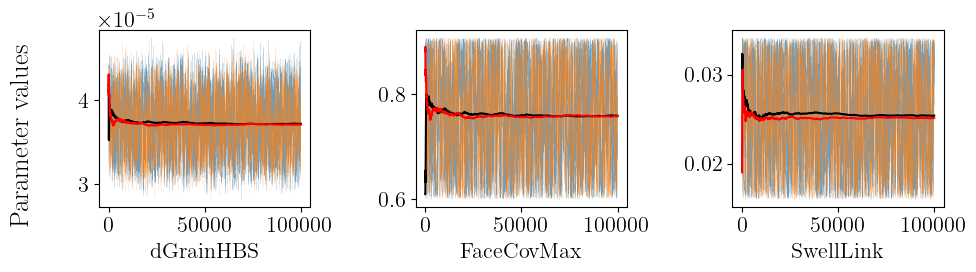

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for i, ax in enumerate(axes.flatten()):
    cdat1 = old1[:,i]
    cavg1 = np.cumsum(cdat1) / np.arange(1, len(cdat1)+1)
    ax.plot(cdat1, lw=0.1, alpha=0.7, zorder=1)
    ax.plot(cavg1, c='k', zorder=2)
    
    cdat2 = old2[:,i]
    cavg2 = np.cumsum(cdat2) / np.arange(1, len(cdat2)+1)
    ax.plot(cdat2, ls='--', lw=0.1, alpha=0.7, zorder=1)
    ax.plot(cavg2, c='r', zorder=2)
    
    ax.set_xlabel(hi_data.columns[i])
    #ax.set_ylim([0, 1])

#fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

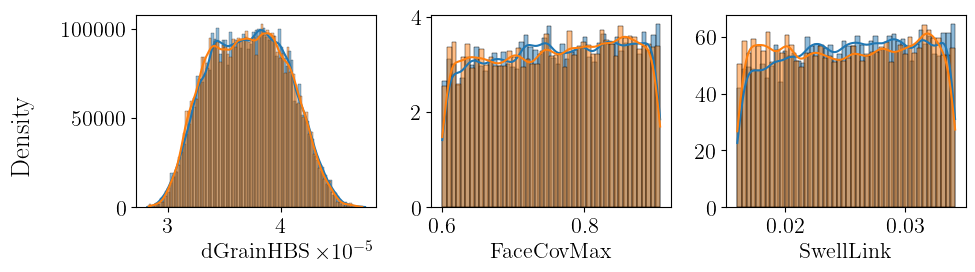

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for i, ax in enumerate(axes.flatten()):
    sns.histplot(old1[:,i], ax=ax, stat='density', kde=True)
    sns.histplot(old2[:,i], ax=ax, stat='density', kde=True)
    ax.set_xlabel(hi_data.columns[i])
    ax.set_ylabel('')
    #ax.set_xlim([0, 1])

#fig.delaxes(axes[1,3])
fig.supylabel('Density')
plt.tight_layout()
plt.show()

# Diagnostics

In [44]:
import arviz as az

In [45]:
azdat = az.convert_to_inference_data(np.stack([hey1, hey2]))
azdat

Inference data with groups:
	> posterior

In [46]:
azdat.posterior.coords

Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 800kB 0 1 2 3 4 5 ... 99996 99997 99998 99999 100000
  * x_dim_0  (x_dim_0) int64 24B 0 1 2

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

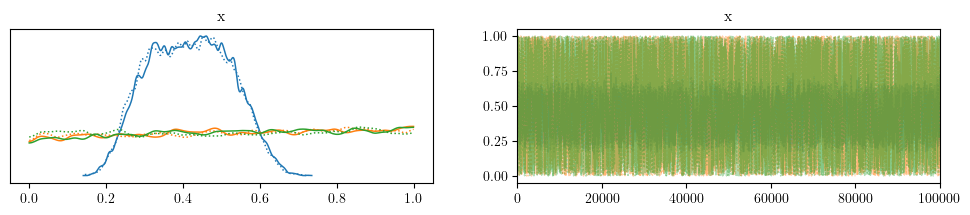

In [47]:
#for i in range(3):
#    az.plot_trace(azdat, var_names=['x'], coords={'x_dim_0': [i]})
az.plot_trace(azdat)

array([[<Axes: title={'center': 'x\n0, 0'}>,
        <Axes: title={'center': 'x\n0, 1'}>,
        <Axes: title={'center': 'x\n0, 2'}>],
       [<Axes: title={'center': 'x\n1, 0'}>,
        <Axes: title={'center': 'x\n1, 1'}>,
        <Axes: title={'center': 'x\n1, 2'}>]], dtype=object)

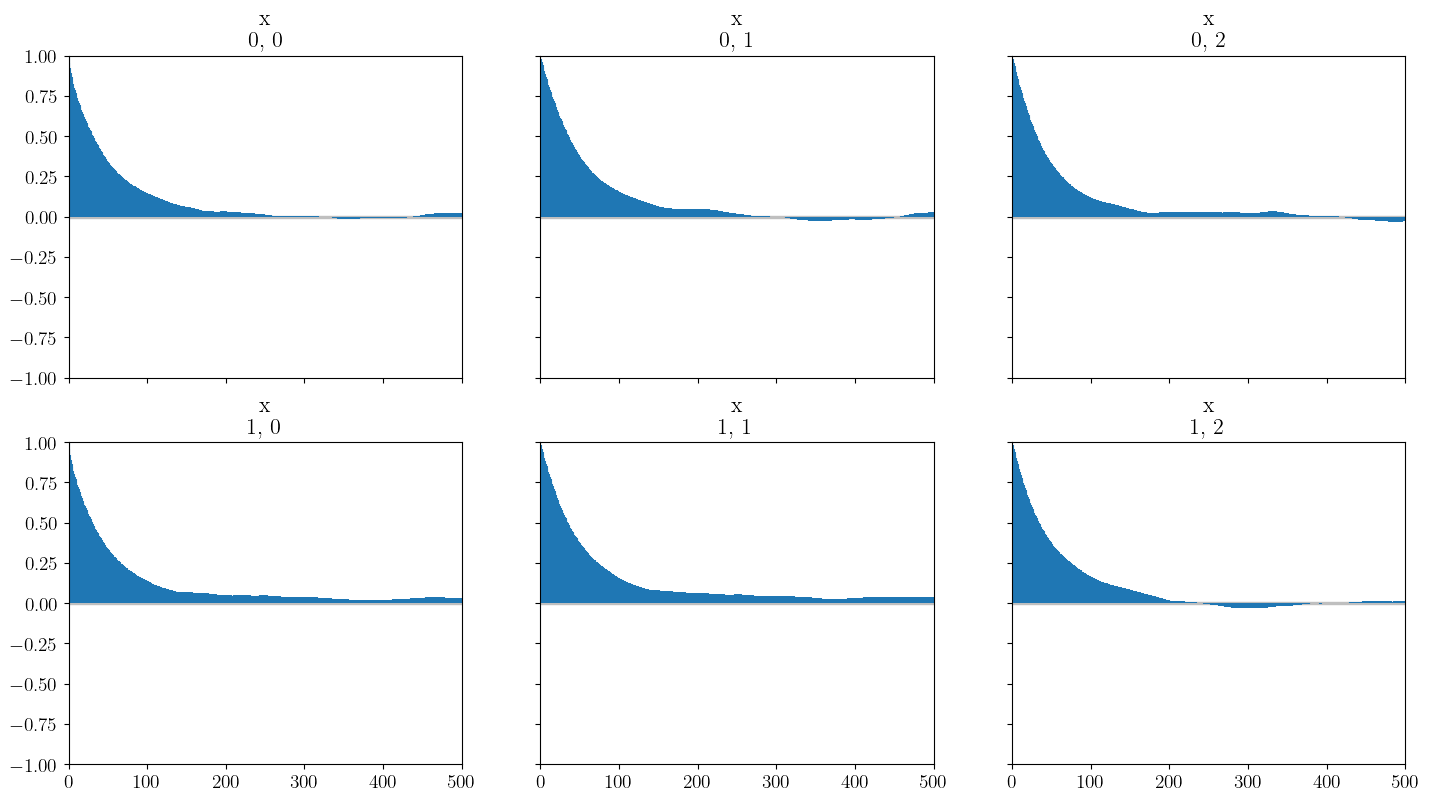

In [48]:
az.plot_autocorr(azdat, max_lag=500)

In [49]:
az.ess(azdat)

<xarray.Dataset> Size: 48B
Dimensions:  (x_dim_0: 3)
Coordinates:
  * x_dim_0  (x_dim_0) int64 24B 0 1 2
Data variables:
    x        (x_dim_0) float64 24B 2.019e+03 1.878e+03 2.122e+03

In [50]:
az.rhat(azdat)

<xarray.Dataset> Size: 48B
Dimensions:  (x_dim_0: 3)
Coordinates:
  * x_dim_0  (x_dim_0) int64 24B 0 1 2
Data variables:
    x        (x_dim_0) float64 24B 1.0 1.0 1.001

# Data thinning

In [51]:
chey = np.concatenate((hey1[::100], hey2[::100]))
cyeh = np.concatenate((yeh1[::100], yeh2[::100]))
cold = np.concatenate((old1[::100], old2[::100]))

In [52]:
chey.shape

(2002, 3)

In [53]:
cold.shape

(2002, 7)

# FUQ

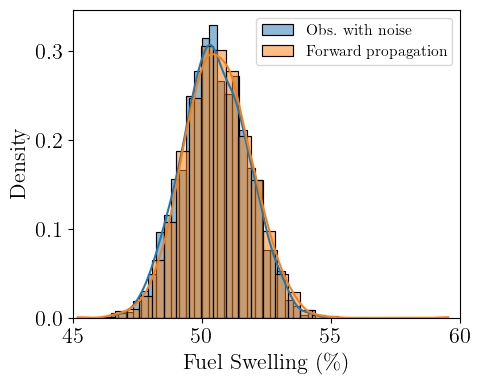

In [54]:
orig = []
res = []
for i in range(2000):
    res.append(reg_gp.predict([chey[-i]])[0])
    #res.append(reg_las3.predict([yeh[-i]])[0])
    c = np.random.normal(swelling_perc(7e21), 1.25)
    orig.append(c)
    
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')

plt.xlim([45, 60])
plt.xlabel(r'Fuel Swelling (\%)')
plt.legend(fontsize='x-small', loc='upper right')
plt.show()

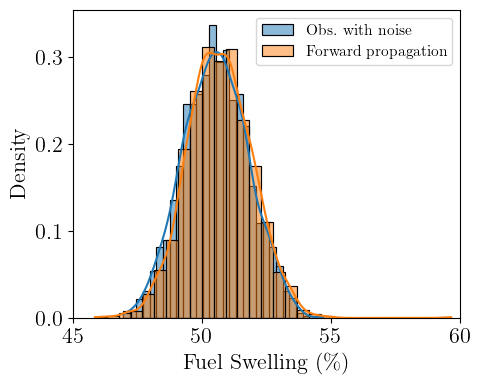

In [55]:
orig = []
res = []
for i in range(2000):
    #res.append(reg_gp.predict([cpy[:3]])[0])
    res.append(reg_las3.predict([cyeh[-i]])[0])
    c = np.random.normal(swelling_perc(7e21), 1.25)
    orig.append(c)
    
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')

plt.xlim([45, 60])
plt.xlabel(r'Fuel Swelling (\%)')
plt.legend(fontsize='x-small', loc='upper right')
plt.show()

<Figure size 1000x800 with 0 Axes>

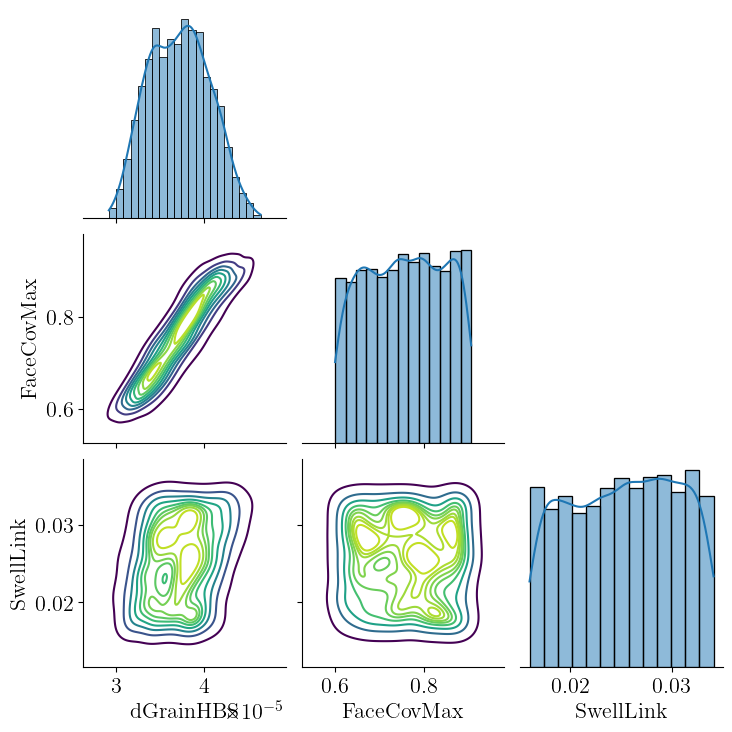

In [56]:
oldd = pd.DataFrame(cold[:,:3], columns=['dGrainHBS', 'FaceCovMax', 'SwellLink'])

plt.figure(figsize=(10, 8))
sns.pairplot(
    pd.DataFrame(oldd),
    diag_kind='hist',
    diag_kws=dict(kde=True),
    plot_kws=dict(cmap='viridis'),
    kind='kde',
    corner=True
)

plt.show()